In [ ]:
# !pip install langchain
# !pip install langchain_community
# !pip install pinecone
# !pip install langchain-google-genai
# !pip install sentence-transformers
# !pip install whisper
# !pip install pytube
# !pip install -U openai-whisper

# Building a RAG application
Retrieval-Augmented Generation (RAG) is a technique that connects large language models (LLMs) to private data by retrieving relevant information from custom data sources, enabling more accurate and context-specific responses, making it highly effective for tasks requiring accurate and context-aware responses, driving its current market trend.



In [2]:
# Let's first import all the important librarires which we will be using
import tempfile
import whisper
from pytube import YouTube
import langchain
import pinecone
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Pinecone
from sentence_transformers import SentenceTransformer
import time
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec
from langchain.chains.question_answering import load_qa_chain
from langchain.schema.output_parser import StrOutputParser
from langchain_community.document_loaders import TextLoader
from sklearn.metrics.pairwise import cosine_similarity
from langchain_community.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from tqdm.autonotebook import tqdm
print("Everything imported succesfully")

Everything imported succesfully


In [3]:
# This is the YouTube video we're going to use
YOUTUBE_VIDEO = "https://www.youtube.com/watch?v=u47GtXwePms"

## Setting up the model
Let's define the LLM model that we'll use as part of the workflow.

In [4]:
model = Ollama(model="llama3")
embedding_model = OllamaEmbeddings(model="jina/jina-embeddings-v2-base-de")
emb_model = SentenceTransformer("all-MiniLM-L6-v2")
print("Model and embedding loaded sucesfully")

d:\Projects\TextLab\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model and embedding loaded sucesfully


The result from the model is an `AIMessage` instance containing the answer. We can extract this answer by chaining the model with an [output parser](https://python.langchain.com/docs/modules/model_io/output_parsers/).Output parsers are responsible for taking the output of an LLM and transforming it to a more suitable format. This is very useful when you are using LLMs to generate any form of structured data.Here is what chaining the model with an output parser looks like:

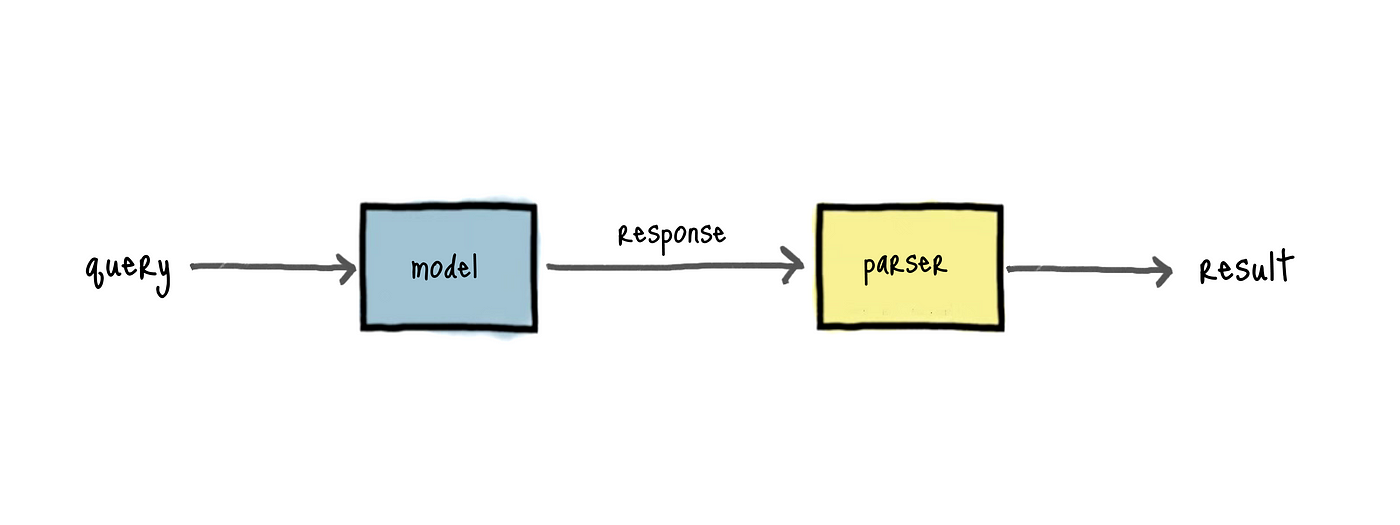

For this example, we'll use a simple `StrOutputParser` to extract the answer as a string.

In [5]:
# Instantiating the StrOutputParser class
parser = StrOutputParser()

# Let's put llm and parser together
chain = model | parser
chain.invoke("What is AI and how it would affect Jobs in future?")

"## Artificial Intelligence (AI): A Brief Overview\n\nArtificial Intelligence (AI) refers to the ability of a machine to perform tasks that typically require human intelligence, such as learning, problem-solving, and decision-making. \n\n**Here's how AI is impacting jobs in the future:**\n\n**Positive Impacts:**\n\n* **Automation:** AI can automate repetitive tasks, freeing up employees for more complex and creative work.\n* **Increased efficiency:** AI can analyze large amounts of data and identify patterns and trends, enabling faster and more accurate decision-making.\n* **Personalized experiences:** AI can tailor products and services to individual needs, leading to increased customer satisfaction.\n* **Reduced costs:** AI can automate tasks and predict maintenance needs, leading to lower operational costs.\n\n**Negative Impacts:**\n\n* **Job displacement:** Some jobs may be replaced by AI, particularly those involving routine tasks.\n* **Skill gap:** Employees who lack the necessar

## Use of prompt templates

We want to provide the model with some context and the question. [Prompt templates](https://python.langchain.com/docs/modules/model_io/prompts/quick_start) are a simple way to define and reuse prompts.

`Prompt templates` are predefined recipes for generating prompts for language models.A template may include instructions, few-shot examples, and specific context and questions appropriate for a given task.LangChain provides tooling to create and work with prompt templates.
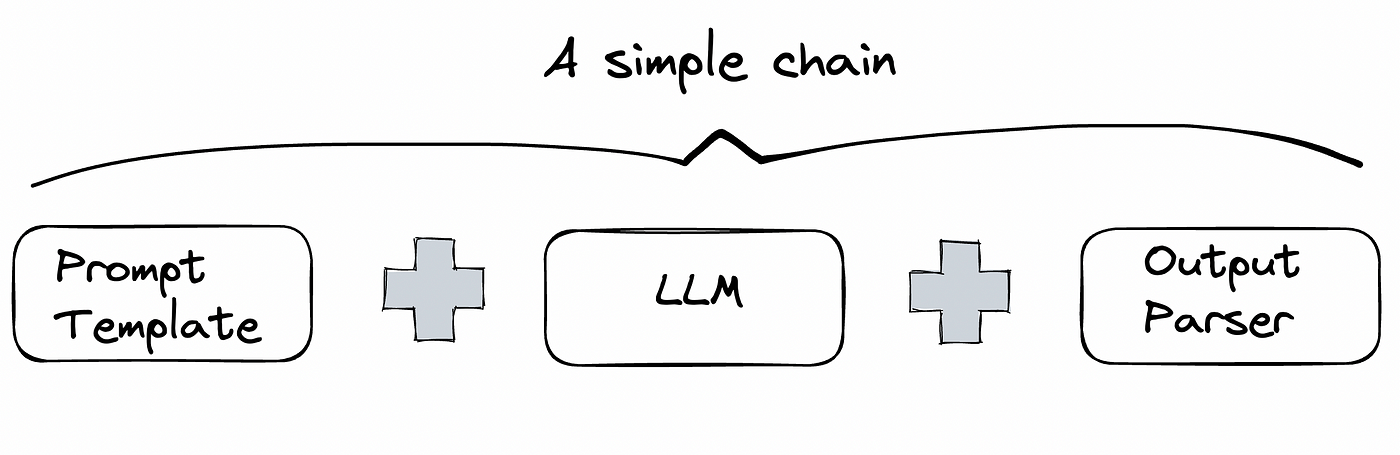

In [6]:
template = """
Answer the question based on the context below. If you can't
answer the question, reply "I don't know".

Context: {context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
formatted_prompt = prompt.format(context="John's favorite color is blue", question="What is John's favorite color?")
print(formatted_prompt)

Human: 
Answer the question based on the context below. If you can't
answer the question, reply "I don't know".

Context: John's favorite color is blue

Question: What is John's favorite color?



In [8]:
chain = prompt | model | parser
chain.invoke({
    "context": "John's favorite color is blue",
    "question": "What is John's favorite color?"
})

"Sure, the context states that John's favorite color is blue, so the answer is John's favorite color is blue."

## Transcribing the YouTube Video

The context we want to send the model comes from a YouTube video. Let's download the video and transcribe it using [OpenAI's Whisper](https://openai.com/research/whisper).

In [8]:
# Loading the whisper model
whisper_model = whisper.load_model("base")

In [ ]:
# Let's do this only if we haven't created the transcription file yet.
if not os.path.exists("/content/video_content.txt"):

    youtube = YouTube(YOUTUBE_VIDEO)
    audio = youtube.streams.filter(only_audio=True).first()

    with tempfile.TemporaryDirectory() as tmpdir:
        file = audio.download(output_path=tmpdir)
        transcription = whisper_model.transcribe(file, fp16=False)["text"].strip()

        with open("/content/video_content.txt", "w") as file:
            file.write(transcription)

Let's read the transcription and display the first few characters to ensure everything works as expected.

In [9]:
with open("../video_content.txt") as file:
    transcription = file.read()

print(transcription[:50])

Hello everyone, now welcome to my Code to Care vid


## Splitting the transcription

Since every LLM have its own contenxt length or winow so we can't use the entire transcription as the context for the model, a potential solution is to split the transcription into smaller chunks. We can then invoke the model using only the relevant chunks to answer a particular question.

In [14]:
loader = TextLoader("../video_content.txt")
transcript_document = loader.load()
transcript_document

[Document(page_content="Hello everyone, now welcome to my Code to Care video series. What I'm doing is I'm rotating through three different types of topics, educational topics, use case topics, and then kind of bias, ethics, safety topics. So now on the education rotation. And today what I wanted to talk about is what is retrieval, augmented generation or reg. And you may think that I'm going into some kind of nook and cranny of the AI field, but this is a very important and popular kind of solution pattern that I see being used over and over and over again for how to leverage large language models. So I thought I would explain it to you. And the thing that this is used for is basically systems that leverage large language models, but on your own content. So let me describe that. If you think of like the chat GPT experience, and if you think about that relative to like the search engine experience that we had before, if you ask a question like, I don't know what color is the sky or how

There are many different ways to split a document. For this example, we'll use a simple splitter that splits the document into chunks of a fixed size. Check [Text Splitters](https://python.langchain.com/docs/modules/data_connection/document_transformers/) for more information about different approaches to splitting documents.

For illustration purposes, let's split the transcription into chunks of 100 characters with an overlap of 20 characters and display the first few chunks:

For our specific application, let's use 1000 characters instead:

In [15]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
documents = text_splitter.split_documents(transcript_document)

## Finding the relevant chunks

Given a particular question, we need to find the relevant chunks from the transcription to send to the model. Here is where the idea of **embeddings** comes into play.

An embedding is a mathematical representation of the semantic meaning of a word, sentence, or document. It's a projection of a concept in a high-dimensional space. Embeddings have a simple characteristic: The projection of related concepts will be close to each other, while concepts with different meanings will lie far away.

To provide with the most relevant chunks, we can use the embeddings of the question and the chunks of the transcription to compute the similarity between them. We can then select the chunks with the highest similarity to the question and use them as the context for the model:

In [12]:
query = "How much the agriculture target will be increased by how many crore?"
query_vector = embedding_model.embed_query(query)
print(len(query_vector))

768


We can now compute the similarity between the query and each of the two sentences. The closer the embeddings are, the more similar the sentences will be.

We can use [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) to calculate the similarity between the query and each of the sentences:

In [71]:
sent1 = "The cat sat on the mat."
sent2 = "The dog lay on the rug."
sent3 = "A bird flew in the sky."

# Let's calculate the cosine similarity between vectors
query_sentence1_similarity = cosine_similarity([embedding_model.embed_query(sent1)], [embedding_model.embed_query(sent2)])[0][0]
query_sentence2_similarity = cosine_similarity([embedding_model.embed_query(sent1)], [embedding_model.embed_query(sent3)])[0][0]

print(query_sentence1_similarity), print(query_sentence2_similarity)

0.39822140774839454
0.14496534011444348


(None, None)

## Setting up a Vector Store

We need an efficient way to store document chunks, their embeddings, and perform similarity searches at scale. To do this, we'll use a **vector store**.
A vector store is a database of embeddings that specializes in fast similarity searches.To understand how a vector store works, let's create one in memory and add a few embeddings to it:

In [80]:
vectorstore1 = DocArrayInMemorySearch.from_texts(
    [
        "Mary's sister is Susana",
        "John and Tommy are brothers",
        "Patricia likes white cars",
        "Pedro's mother is a teacher",
        "Lucia drives an Audi",
        "Mary has two siblings",
    ],
    embedding=embedding_model,
)

vectorstore1.similarity_search_with_score(query="Who is Mary's sister?", k=3)

[(Document(page_content="Mary's sister is Susana"), 0.7240693382795919),
 (Document(page_content='Mary has two siblings'), 0.7027734891206073),
 (Document(page_content="Pedro's mother is a teacher"), 0.34914534153897814)]

In [74]:
retriever1 = vectorstore1.as_retriever()
retriever1.invoke("Who is Mary's sister?")

[Document(page_content="Mary's sister is Susana"),
 Document(page_content='Mary has two siblings'),
 Document(page_content="Pedro's mother is a teacher"),
 Document(page_content='John and Tommy are brothers')]

## Loading transcription into the vector store

We initialized the vector store with a few random strings. Let's create a new vector store using the chunks from the video transcription.So far we've used an in-memory vector store. In practice, we need a vector store that can handle large amounts of data and perform similarity searches at scale. For this example, we'll use [Pinecone](https://www.pinecone.io/).

The first step is to create a Pinecone account, set up an index, get an API key, and set it as an environment variable `PINECONE_API_KEY`.Then, we can load the transcription documents into Pinecone:

In [10]:
# Setup for Pinecone vector database
pc = Pinecone(api_key=os.environ['PINECONE_API_KEY'])
index_name = "ragvideo"

# Getting the index reference
index = pc.Index(index_name)

In [77]:
if index_name in pc.list_indexes().names():
    pc.delete_index(index_name)
else:
    # Creating a new index
    pc.create_index(
        name=index_name,
        dimension=768,
        metric="cosine",
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )

# Getting the index reference
index = pc.Index(index_name)

In [16]:
pinecone = PineconeVectorStore.from_documents(
    documents, embedding_model, index_name=index_name,pinecone_api_key=os.environ['PINECONE_API_KEY']
)

Let's now run a similarity search on pinecone to make sure everything works:

In [20]:
results = pinecone.similarity_search("How does RAG differ from traditional search engines?")[:3]
results

[Document(page_content="I fix this plumbing issue or something like that, a search engine would go out or appear to go out, search the internet, find relevant content, and then just list that content for you. List those links and then you as a user would need to click on the links that seem, seem right, read it, digest it, and figure out the answer to your question. What a large language model does is it seems to do that first part, meaning leverage the content on the whole internet. But instead of just listing that content, it sort of digest ship, digest it, combines it, assembles it together, and answers your question, sort of generates an answer. So it's a whole lot better. I mean, search engines haven't been great, but this is taking the whole experience to another level. And it is a question and answering. Now you can also give it instructions like write me this document or write me a lesson plan to teach geometry to seventh graders, and it will do something similar. It will kind 

Let's test what our rag on the question : How does RAG differ from traditional search engines?

In [27]:
chain = (
    {"context": pinecone.as_retriever(), "question": RunnablePassthrough()}
    | prompt
    | model
    | parser
)

chain.invoke("How does RAG differ from traditional search engines?")

'According to the context, a large language model (LLoM) "sort of digest[s] it, combines it, assembles it together, and answers your question" instead of just listing relevant content like traditional search engines. Additionally, an LLoM can generate an answer based on the combined information, whereas a traditional search engine would require the user to click on links and read through multiple sources to find the answer themselves.'